In [ ]:
import pandas as pd

DATA_PATH = "dataset_for_classifier_Reddit.csv"
df = pd.read_csv(DATA_PATH)
df.head()

In [ ]:
# Standard Libraries
import pandas as pd
import numpy as np
import json

# Data Preprocessing & NLP
import nltk
import re
import string
import gensim
from textblob import Word

# Data Cleaning
def clean_text(text):
    # remove everything except alphabets
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    # remove whitespaces
    text = ' '.join(text.split())
    
    
    return text

In [ ]:
# creating clean text feature
features = ['sentence']
for feature in features:
    df['clean_' + feature] = df[feature].apply(clean_text)

In [ ]:
df.head()

In [ ]:
df['soup'] = df['clean_sentence']

In [ ]:
df.head()

In [ ]:
!pip install transformers
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install --upgrade --force-reinstall --no-deps transformers
!pip install --upgrade --force-reinstall --no-deps datasets
!pip install --upgrade --force-reinstall --no-deps huggingface_hub
!pip install --upgrade --force-reinstall --no-deps pyarrow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached transformers-4.26.1-py3-none-any.whl (6.3 MB)
  Attempting uninstall: transformers
    Found existing installation: transformers 4.26.1
    Uninstalling transformers-4.26.1:
      Successfully uninstalled transformers-4.26.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached datasets-2.10.1-py3-none-any.whl (469 kB)
  Attempting uninstall: datasets
    Found existing installation: datasets 2.10.1
    Uninstalling datasets-2.10.1:
      Successfully uninstalled datasets-2.10.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached huggingface_hub-0.13.0-py3-none-any.whl (199 kB)
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.13.0
    Uninstalling huggingface-hub-0.13.0:
      Successfully uninstalled huggingface

In [ ]:
from datasets import Dataset

ds = Dataset.from_pandas(df)
ds

Dataset({
    features: ['sentence', 'sentence_id', 'assignment_id', 'worker_id', 'worker_life_time_approval_rate', 'worker_last_30_days_approval_rate', 'worker_last_7_days_approval_rate', 'sentence_group_number', 'expresses_a_need_grouped', 'expresses_a_need_final', 'is_question', 'has_question_mark', 'has_annotations', 'labels', 'clean_sentence', 'soup'],
    num_rows: 3227
})

In [ ]:
from datasets import load_dataset,DatasetDict
from transformers import AutoTokenizer,TFAutoModelForSequenceClassification
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

dataset = load_dataset('csv', data_files=DATA_PATH, split='train')

dataset

Dataset({
    features: ['sentence', 'sentence_id', 'assignment_id', 'worker_id', 'worker_life_time_approval_rate', 'worker_last_30_days_approval_rate', 'worker_last_7_days_approval_rate', 'sentence_group_number', 'expresses_a_need_grouped', 'expresses_a_need_final', 'is_question', 'has_question_mark', 'has_annotations', 'labels'],
    num_rows: 3227
})

In [ ]:
train_test_valid = ds.train_test_split()

test_valid = train_test_valid['test'].train_test_split()

train_test_valid_dataset = DatasetDict({
    'train': train_test_valid['train'],
    'test': test_valid['test'],
    'valid': test_valid['train']
    })


dataset = train_test_valid_dataset.remove_columns(['sentence_id', 'assignment_id', 'worker_id', 'worker_life_time_approval_rate', 'worker_last_30_days_approval_rate', 'worker_last_7_days_approval_rate', 'sentence_group_number','expresses_a_need_grouped','is_question', 'has_question_mark', 'has_annotations', 'labels'])
dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'expresses_a_need_final', 'clean_sentence', 'soup'],
        num_rows: 2420
    })
    test: Dataset({
        features: ['sentence', 'expresses_a_need_final', 'clean_sentence', 'soup'],
        num_rows: 202
    })
    valid: Dataset({
        features: ['sentence', 'expresses_a_need_final', 'clean_sentence', 'soup'],
        num_rows: 605
    })
})

In [ ]:
gs_folder_bert = "gs://cloud-tpu-checkpoints/bert/v3/uncased_L-12_H-768_A-12"
tf.io.gfile.listdir(gs_folder_bert)

['bert_config.json',
 'bert_model.ckpt.data-00000-of-00001',
 'bert_model.ckpt.index',
 'vocab.txt']

In [ ]:
import json
import os
bert_config_file = os.path.join(gs_folder_bert, "bert_config.json")
config_dict = json.loads(tf.io.gfile.GFile(bert_config_file).read())
config_dict

{'attention_probs_dropout_prob': 0.1,
 'hidden_act': 'gelu',
 'hidden_dropout_prob': 0.1,
 'hidden_size': 768,
 'initializer_range': 0.02,
 'intermediate_size': 3072,
 'max_position_embeddings': 512,
 'num_attention_heads': 12,
 'num_hidden_layers': 12,
 'type_vocab_size': 2,
 'vocab_size': 30522}

In [ ]:
!pip install -q tf-models-official

In [ ]:
import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_models as tfm
import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

# Configuration for "bert-base-cased"
config_dict = {
    "attention_probs_dropout_prob": 0.1,
    "hidden_act": "gelu",
    "hidden_dropout_prob": 0.1,
    "hidden_size": 768,
    "initializer_range": 0.02,
    "intermediate_size": 3072,
    "max_position_embeddings": 512,
    "num_attention_heads": 12,
    "num_hidden_layers": 12,
    "type_vocab_size": 2,
    "vocab_size": 28996
}

encoder_config = tfm.nlp.encoders.EncoderConfig({
    'type': 'bert',
    'bert': config_dict
})

bert_encoder = tfm.nlp.encoders.build_encoder(encoder_config)
bert_encoder.summary()

Model: "bert_encoder_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 word_embeddings (OnDeviceEmbed  (None, None, 768)   22268928    ['input_word_ids[0][0]']         
 ding)                                                                                            
                                                                                                  
 input_type_ids (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 position_embedding (PositionEm  (None, None, 768)   393216      ['word_embeddings[0]

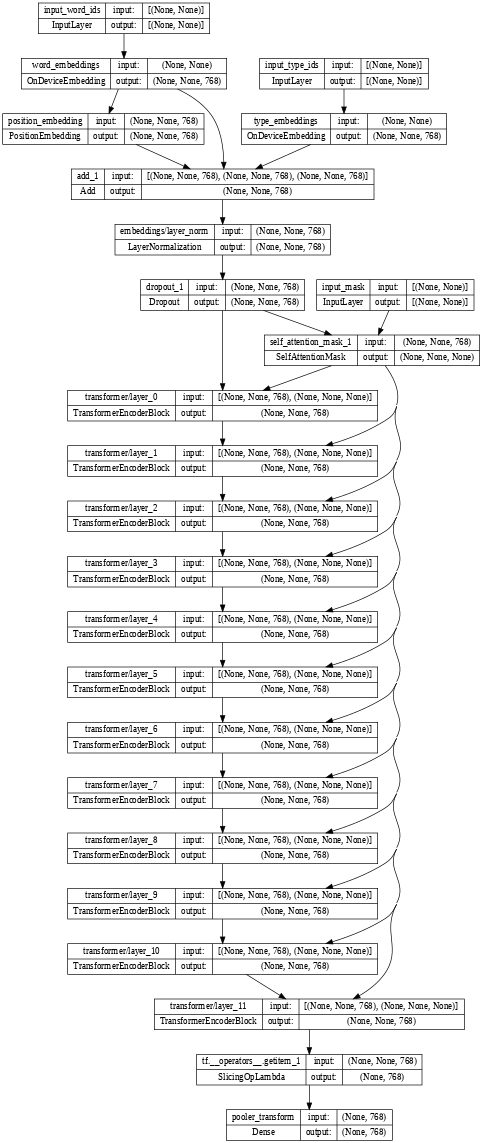

In [ ]:
tf.keras.utils.plot_model(bert_encoder, show_shapes=True, dpi=48)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

In [ ]:
text = "Just checking tokenization"

output = tokenizer(text)

output

{'input_ids': [101, 2066, 9444, 22559, 2734, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1]}

In [ ]:
tokens = tokenizer.convert_ids_to_tokens(output['input_ids'])
tokens

['[CLS]', 'Just', 'checking', 'token', '##ization', '[SEP]']

In [ ]:
print(f"Tokenized text: {tokenizer.convert_tokens_to_string(tokens)}")

Tokenized text: [CLS] Just checking tokenization [SEP]


In [ ]:
print(f"Vocab size is : {tokenizer.vocab_size}")

print(f"Model max length is : {tokenizer.model_max_length}")

print(f"Model input names are: {tokenizer.model_input_names}")

Vocab size is : 28996
Model max length is : 512
Model input names are: ['input_ids', 'token_type_ids', 'attention_mask']


In [ ]:
ds

Dataset({
    features: ['sentence', 'sentence_id', 'assignment_id', 'worker_id', 'worker_life_time_approval_rate', 'worker_last_30_days_approval_rate', 'worker_last_7_days_approval_rate', 'sentence_group_number', 'expresses_a_need_grouped', 'expresses_a_need_final', 'is_question', 'has_question_mark', 'has_annotations', 'labels', 'clean_sentence', 'soup'],
    num_rows: 3227
})

In [ ]:
def tokenize_function(train_dataset):
    return tokenizer(train_dataset['sentence'], padding='max_length', truncation=True) 


tokenized_dataset = dataset.map(tokenize_function, batched=True)

tokenized_dataset

train_dataset = tokenized_dataset['train']
eval_dataset = tokenized_dataset['valid']
test_dataset = tokenized_dataset['test']

Map:   0%|          | 0/2420 [00:00<?, ? examples/s]

Map:   0%|          | 0/202 [00:00<?, ? examples/s]

Map:   0%|          | 0/605 [00:00<?, ? examples/s]

In [ ]:
train_dataset

Dataset({
    features: ['sentence', 'expresses_a_need_final', 'clean_sentence', 'soup', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 2420
})

In [ ]:
train_set = train_dataset.remove_columns(['sentence', 'clean_sentence']).with_format('tensorflow')

tf_eval_dataset = eval_dataset.remove_columns(['sentence', 'clean_sentence']).with_format('tensorflow')

tf_test_dataset = test_dataset.remove_columns(['sentence', 'clean_sentence']).with_format('tensorflow')

In [ ]:
# Set up epochs and steps
#epochs = 5
Epochs = 10
batch_size = 32
eval_batch_size = 32
initial_learning_rate=2e-5

In [ ]:
train_features = { x: train_set[x] for x in tokenizer.model_input_names  }

train_set_for_final_model = tf.data.Dataset.from_tensor_slices((train_features, train_set['expresses_a_need_final'] ))

train_set_for_final_model = train_set_for_final_model.shuffle(len(train_set)).batch(batch_size)


eval_features = {x: tf_eval_dataset[x] for x in tokenizer.model_input_names}
val_set_for_final_model = tf.data.Dataset.from_tensor_slices((eval_features, tf_eval_dataset['expresses_a_need_final']))
val_set_for_final_model = val_set_for_final_model.batch(eval_batch_size)

test_features = {x: tf_test_dataset[x] for x in tokenizer.model_input_names}
test_set_for_final_model = tf.data.Dataset.from_tensor_slices((test_features, tf_test_dataset['expresses_a_need_final']))
test_set_for_final_model =test_set_for_final_model.batch(batch_size)

In [ ]:
model = TFAutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=2)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=tf.metrics.SparseCategoricalAccuracy(),
)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
76/76 [==============================] - 5567s 72s/step - loss: 0.6905 - sparse_categorical_accuracy: 0.5657 - val_loss: 0.6968 - val_sparse_categorical_accuracy: 0.5190
Epoch 2/10
76/76 [==============================] - 5479s 72s/step - loss: 0.6737 - sparse_categorical_accuracy: 0.5789 - val_loss: 0.7086 - val_sparse_categorical_accuracy: 0.5091
Epoch 3/10
76/76 [==============================] - 5556s 73s/step - loss: 0.6092 - sparse_categorical_accuracy: 0.6752 - val_loss: 0.7445 - val_sparse_categorical_accuracy: 0.5107
Epoch 4/10
76/76 [==============================] - 5494s 72s/step - loss: 0.4118 - sparse_categorical_accuracy: 0.8244 - val_loss: 0.9830 - val_sparse_categorical_accuracy: 0.5372
Epoch 5/10
76/76 [==============================] - 5466s 72s/step - loss: 0.1749 - sparse_categorical_accuracy: 0.9417 - val_loss: 1.3164 - val_sparse_categorical_accuracy: 0.5339
Epoch 6/10
76/76 [==============================] - 5577s 73s/step - loss: 0.0844 - sparse_cate

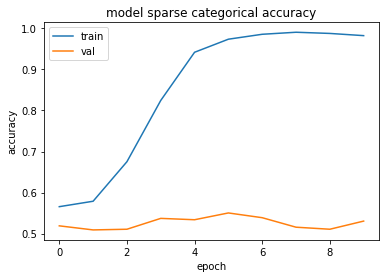

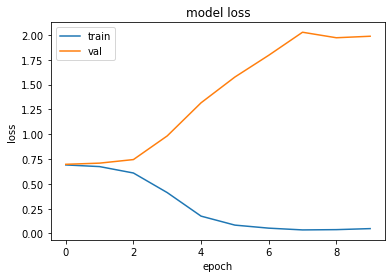

In [ ]:
history = model.fit(train_set_for_final_model, 
                    validation_data=val_set_for_final_model,
                    epochs=Epochs)

import matplotlib.pyplot as plt
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model sparse categorical accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()